In [41]:
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.initializers import Constant
from keras.layers import TextVectorization
import numpy as np
import pickle
import json

In [42]:
X = np.load('data/X.npy', allow_pickle=True)
y = np.load('data/y.npy')
embedding_matrix = np.load('data/embedding_matrix.npy')
num_tokens = np.load('data/num_tokens.npy').item()
embedding_dim = np.load('data/embedding_dim.npy').item()
max_tokens = np.load('data/max_tokens.npy').item()
max_len = np.load('data/max_len.npy').item()

In [43]:
vectorizer = TextVectorization(max_tokens=max_tokens,
                               standardize=None,
                               ngrams=(1, 2),
                               output_sequence_length=max_len)
vectorizer.adapt(X)

2022-02-02 19:34:55.511996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [44]:
y = y.reshape((-1,1))

In [45]:
print(X.shape)
print(y.shape)

(7613,)
(7613, 1)


In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
np.save('data/x_train.npy', x_train)
np.save('data/y_train.npy', y_train)
np.save('data/x_test.npy', x_test)
np.save('data/y_test.npy', y_test)

In [48]:
sequences_input = Input(shape=(1), dtype='string')

vectorizer_sequence = vectorizer(sequences_input)

embedding_layer = Embedding(num_tokens,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)
embedded_sequences = embedding_layer(vectorizer_sequence)

x = Bidirectional(GRU(32, return_sequences=True))(embedded_sequences)
x = Dropout(0.2)(x)
x = Bidirectional(GRU(16, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = Dense(10, activation="relu")(x)
x = Dropout(0.2)(x)

preds = Dense(units=1,
              kernel_initializer='uniform',
              activation='sigmoid')(x)
model = Model(sequences_input, preds)

model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 68)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 68, 100)           5000200   
                                                                 
 bidirectional_4 (Bidirectio  (None, 68, 64)           25728     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 68, 64)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 68, 32)           7872

In [49]:
n_samples = x_train.shape[0]
model_n = 6

history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    batch_size=int(n_samples*0.1),
                    epochs=200)

model.save(f'models/model{model_n}.tf')

with open(f'models/history{model_n}.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/200


2022-02-02 19:35:00.957110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.401349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.415601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.635537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.663540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.940317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:01.966955: I tensorflow/core/grappler/optimizers/cust

8/8 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5548

2022-02-02 19:35:04.054886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:04.211678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:04.220859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:04.404865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:35:04.411895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 8s 315ms/step - loss: 0.6925 - accuracy: 0.5548 - val_loss: 0.6908 - val_accuracy: 0.5807
Epoch 2/200
8/8 [==============================] - 1s 183ms/step - loss: 0.6896 - accuracy: 0.5785 - val_loss: 0.6871 - val_accuracy: 0.5769
Epoch 3/200
8/8 [==============================] - 1s 187ms/step - loss: 0.6862 - accuracy: 0.5776 - val_loss: 0.6821 - val_accuracy: 0.5788
Epoch 4/200
8/8 [==============================] - 1s 178ms/step - loss: 0.6805 - accuracy: 0.5829 - val_loss: 0.6756 - val_accuracy: 0.5865
Epoch 5/200
8/8 [==============================] - 1s 181ms/step - loss: 0.6744 - accuracy: 0.5895 - val_loss: 0.6679 - val_accuracy: 0.5966
Epoch 6/200
8/8 [==============================] - 1s 174ms/step - loss: 0.6657 - accuracy: 0.6018 - val_loss: 0.6565 - val_accuracy: 0.6074
Epoch 7/200
8/8 [==============================] - 1s 172ms/step - loss: 0.6466 - accuracy: 0.6190 - val_loss: 0.6185 - val_accuracy: 0.6515
Epoch 8/200
8/8 [========

2022-02-02 19:39:50.160200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: models/model6.tf/assets


INFO:tensorflow:Assets written to: models/model6.tf/assets


In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [51]:
y_pred = model.predict(x_test)

2022-02-02 19:40:04.105386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:40:04.264523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:40:04.273502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:40:04.470161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 19:40:04.477476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [52]:
y_pred = np.array([np.max(probs[:, 0]) for probs in y_pred])

In [53]:
def evaluate(y_true, y_pred, thresh):
    y_pred_ = (y_pred > thresh).astype(int)
    return accuracy_score(y_true, y_pred_), y_pred_

In [54]:
best_thresh = 0
best_accuracy = 0

for i in np.arange(0, 1, 0.01):
    print(f'Calculating thresh: {i}')
    score, _ = evaluate(y_test, y_pred, i)
    print(f'Accuracy: {score}')
    if score > best_accuracy:
        best_accuracy = score
        best_thresh = i

Calculating thresh: 0.0
Accuracy: 0.41825344714379514
Calculating thresh: 0.01
Accuracy: 0.41825344714379514
Calculating thresh: 0.02
Accuracy: 0.41825344714379514
Calculating thresh: 0.03
Accuracy: 0.41825344714379514
Calculating thresh: 0.04
Accuracy: 0.41825344714379514
Calculating thresh: 0.05
Accuracy: 0.41825344714379514
Calculating thresh: 0.06
Accuracy: 0.41825344714379514
Calculating thresh: 0.07
Accuracy: 0.41825344714379514
Calculating thresh: 0.08
Accuracy: 0.4189100459619173
Calculating thresh: 0.09
Accuracy: 0.4195666447800394
Calculating thresh: 0.1
Accuracy: 0.4208798424162837
Calculating thresh: 0.11
Accuracy: 0.4241628365068943
Calculating thresh: 0.12
Accuracy: 0.4313854235062377
Calculating thresh: 0.13
Accuracy: 0.44714379514116875
Calculating thresh: 0.14
Accuracy: 0.4727511490479317
Calculating thresh: 0.15
Accuracy: 0.505581089954038
Calculating thresh: 0.16
Accuracy: 0.5397242284963887
Calculating thresh: 0.17
Accuracy: 0.5659881812212738
Calculating thresh: 0.

In [55]:
score, y_pred = evaluate(y_test, y_pred, best_thresh)
print(score)

0.7925147734734077


In [56]:
y_pred_train = model.predict(x_train)
y_pred_train = np.array([np.max(probs[:, 0]) for probs in y_pred_train])
evaluate(y_train, y_pred_train, best_thresh)

(0.8054187192118226, array([0, 0, 0, ..., 0, 1, 0]))

In [57]:
confusion_matrix(y_test, y_pred)

array([[786, 100],
       [216, 421]])

In [58]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [59]:
history = history.history

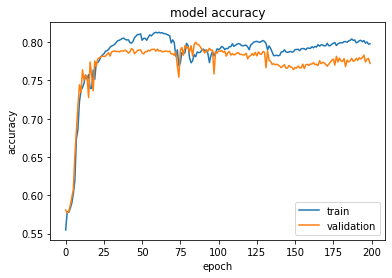

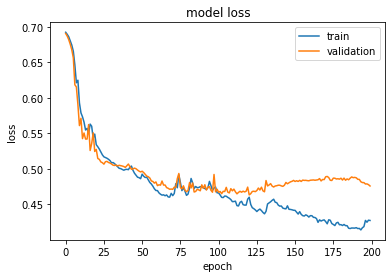

In [60]:
plt.subplots()
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.subplots()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()